# Dispersion Engineering

In [1]:
import numpy as np
from numpy.fft import fft, ifft, fftshift, fftfreq
import matplotlib.pyplot as plt
from matplotlib import cm
import colorcet as cc

#This are my libraries
import nlo
import pulses
import materials
import waveguides

#Larger font for plots
plt.rcParams.update({'font.size': 18})

## Units
We'll work in SI base units for the most part. Here we load some constants and also create some variables for scaling units conveniently.

In [2]:
from scipy.constants import pi, c, epsilon_0
nm = 1e-9
um = 1e-6
mm = 1e-3
ps = 1e-12
fs = 1e-15
GHz = 1e9
THz = 1e12
pJ = 1e-12
mW = 1e-3

In [3]:
wl_ff = 1559*nm #Fundamental wavelength
# wl_ff = 1.59*um
f0_ff = c/wl_ff

#Let's set the bandwdith
f_max = c/(500*nm)
f_min = c/(1.6*um)
BW = f_max - f_min 

#Now we can create the time and frequency arrays
NFFT = 2**11
Tmax = NFFT/BW
dt = 1/BW
t_start = -0.5*ps
t_stop = t_start + NFFT*dt
t = np.arange(t_start, t_stop, step=dt)
f = fftfreq(NFFT, dt)
Omega = 2*pi*f
df = f[1]-f[0]

We also need to choose a reference frequency $f_{ref}$. Our simulation is a bandpass simulation centered around this reference frequency. So, the natural frequency variable for our simulation is $$\Omega = \omega - \omega_{ref}.$$
I'll try to be consistent and use lower case variable names for absolute frequencies representing $\omega$'s, and variable names starting with an uppper case to represent $\Omega$. For, instance, the variable ```Omega``` that we just created represents $\Omega$, while in the next cell we'll define ```omega_ref``` and ```omega_abs``` which represents $\omega_{ref}$ and $\omega$.

In [4]:
#Reference frequency
f_ref = (f_min + f_max)/2
wl_ref = c/f_ref
omega_ref = 2*pi*f_ref

#Absolute frequencies and wavelengths
f_abs = f + f_ref
wl_abs = c/f_abs
omega_abs = 2*pi*f_abs
f_min = np.amin(f_abs)
f_max = np.amax(f_abs)
wl_max = c/f_min
wl_min = c/f_max

#get the frequency indexes
f0_ff_index = np.abs(f + f_ref - f0_ff).argmin()
f_ref_index = np.abs(f).argmin()

## Waveguide

Refractive index at fundamental = 1.957


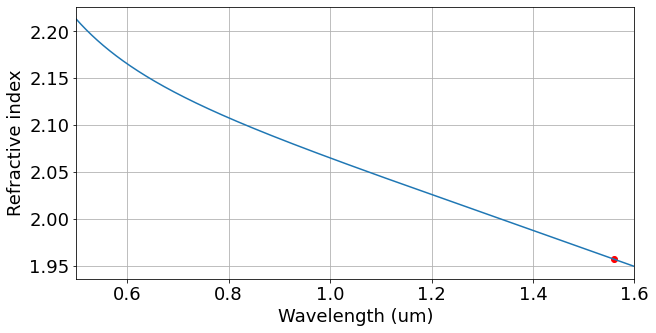

In [5]:
width = 1800*nm
hLN = 700*nm
hetch = 350*nm

wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch)
wg.add_narray(wl_abs) #This calculates neff at all wavelengths
n = wg.neff_array
nw = n[f0_ff_index]

plt.rcParams['figure.figsize'] = [10, 5]
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(fftshift(wl_abs/um), fftshift(n))
ax1.scatter(wl_abs[f0_ff_index]/um, nw, c='r')
ax1.set_xlim([wl_min/um, wl_max/um])
ax1.set_xlabel('Wavelength (um)')
ax1.set_ylabel('Refractive index')
ax1.grid(True)

print('Refractive index at fundamental = %0.3f' %(nw))

beta = omega_abs*n/c
beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
vg = 1/beta_1

f_v_ref = f0_ff
f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
v_ref = vg[f_v_ref_index]
GVM = 1/v_ref - 1/vg

Now we'll get the propagation constant as usual:
$$ \beta = \frac{\omega n}{c} ,$$

as well as the group velocity and GVD:
$$ 
v_g = \frac{1}{\beta_1} = \left( \frac{\partial \beta}{\partial \omega} \right)^{-1} \\
\mathrm{GVD} = \beta_2 = \frac{\partial^2 \beta}{\partial \omega^2} .
$$

We also need to get the higher order dispersion operator; this can be obtained from the propagation constant as follows:
$$D = \beta(\Omega) - \beta \big|_{\Omega=0} - \frac{\Omega}{v_{ref}}.$$

For this example we'll use $v_{ref} = v_g(2 \omega_0)$.

At this point we can also compute the GVM ($\Delta \beta^\prime $) between the fundamental signal and the moving reference frame:
$$ \Delta \beta^\prime = \frac{1}{v_{ref}} - \frac{1}{v_g(\omega_0)}, $$
and then we can compute how much a pulse at $\omega_0$ will travel in a crystal of length $L$,
$$ \tau =  L \Delta \beta^\prime. $$

In [7]:
b1 = wg.beta1(wl_abs)

GVM between 1559.0 nm and 779.5 nm = -145.810 fs/mm
GVD at 779.5 nm = 301.3 fs^2/mm
GVD at 1559.0 nm = -53.5 fs^2/mm


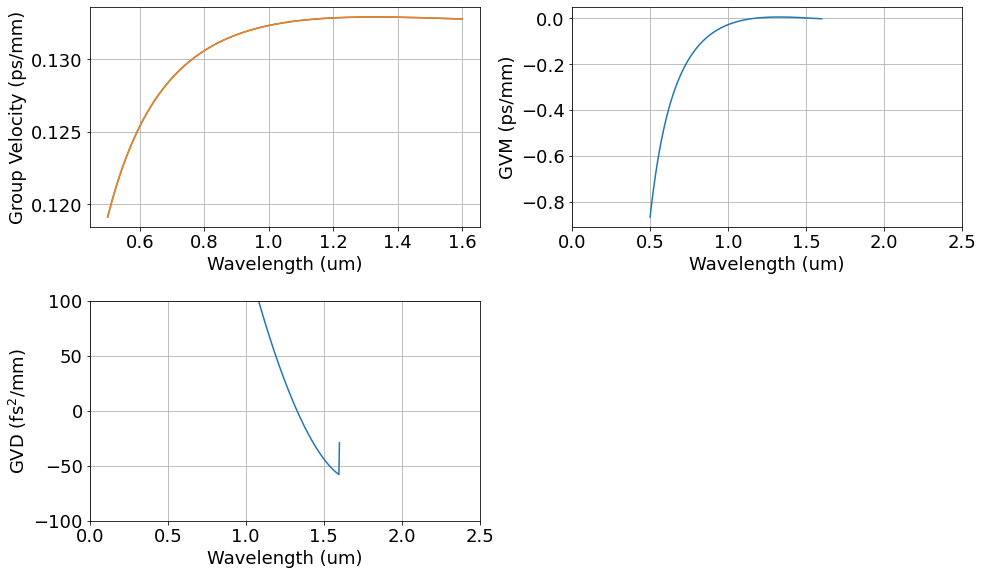

In [8]:
plt.rcParams['figure.figsize'] = [14, 16]
fig = plt.figure()
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)

ax1.plot(fftshift(wl_abs)/um, fftshift(vg)/(mm/ps));
ax1.set_ylabel('Group Velocity (ps/mm)'); ax1.set_xlabel('Wavelength (um)');

ax1.plot(fftshift(wl_abs)/um, fftshift(1/b1)/(mm/ps));

ax2.plot(fftshift(wl_abs)/um, fftshift(GVM)/(ps/mm));
ax2.set_ylabel('GVM (ps/mm)'); ax2.set_xlabel('Wavelength (um)');

ax3.plot(fftshift(wl_abs)/um, fftshift(beta_2)/(fs**2/mm));
ax3.set_ylabel('GVD (fs$^2$/mm)'); ax3.set_xlabel('Wavelength (um)');

ax1.grid(True); ax2.grid(True); ax3.grid(True);

ax2.set_xlim([0,2.5])
ax3.set_xlim([0,2.5])
ax3.set_ylim([-100,100])

fig.tight_layout()

#Print stuff
f0_sh_index = np.abs(f + f_ref - 2*f0_ff).argmin()
print('GVM between %0.1f nm and %0.1f nm = %0.3f fs/mm' %(c/f_v_ref/nm, c/(2*f0_ff)/nm, GVM[f0_sh_index]/(fs/mm)) )
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(c/(2*f0_ff)/nm, beta_2[f0_sh_index]/(fs**2/mm) ) )
print('GVD at %0.1f nm = %0.1f fs^2/mm' %(c/f0_ff/nm, beta_2[f0_ff_index]/(fs**2/mm) ) )

In [20]:
(wg.beta1(1.559*um) - wg.beta1(1.559*um/2))/(fs/mm)

-145.79369262482015

In [19]:
(beta_1[f0_sh_index] - beta_1[f0_ff_index])/(fs/mm)

145.8095645534767

## Sweeps

In [7]:
hLN = 700*nm
width = np.arange(800*nm, 4*um, 200*nm)
etch = np.array([350*nm])

GVM = np.zeros([width.size, etch.size])
GVD2 = np.zeros([width.size, etch.size])
GVD1 = np.zeros([width.size, etch.size])

ke = 0
for kw in range(width.size):
    wg = waveguides.waveguide(w_top=width[kw], h_ridge=hLN, h_slab=hLN-etch[ke])
    wg.add_narray(wl_abs) #This calculates neff at all wavelengths
    n = wg.neff_array
    beta = omega_abs*n/c
    beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
    beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
    vg = 1/beta_1

    f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
    v_ref = vg[f_v_ref_index]
    
    gvm = 1/v_ref - 1/vg
    
    GVM[kw, ke] = gvm[f0_sh_index]
    GVD1[kw, ke] = beta_2[f0_ff_index]
    GVD2[kw, ke] = beta_2[f0_sh_index]

KeyboardInterrupt: 

In [ ]:
plt.rcParams['figure.figsize'] = [12, 16]
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(width/um, GVM[:,0]/(fs/mm))
ax2.plot(width/um, GVD1[:,0]/(fs**2/mm))
ax3.plot(width/um, GVD2[:,0]/(fs**2/mm))

ax1.grid(True); ax2.grid(True); ax3.grid(True);
fig.tight_layout()

## Etch

In [ ]:
hLN = 700*nm
width = np.array([1850*nm])
etch = np.arange(200*nm, 551*nm, 50*nm)

GVM = np.zeros([width.size, etch.size])
GVD2 = np.zeros([width.size, etch.size])
GVD1 = np.zeros([width.size, etch.size])

kw = 0
for ke in range(etch.size):
    print(etch[ke]/nm)
    wg = waveguides.waveguide(w_top=width[kw], h_ridge=hLN, h_slab=hLN-etch[ke])
    wg.add_narray(wl_abs) #This calculates neff at all wavelengths
    n = wg.neff_array
    beta = omega_abs*n/c
    beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
    beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
    vg = 1/beta_1

    f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
    v_ref = vg[f_v_ref_index]
    
    gvm = 1/v_ref - 1/vg
    
    GVM[kw, ke] = gvm[f0_sh_index]
    GVD1[kw, ke] = beta_2[f0_ff_index]
    GVD2[kw, ke] = beta_2[f0_sh_index]

In [ ]:
plt.rcParams['figure.figsize'] = [12, 16]
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.plot(etch/um, GVM[0,:]/(fs/mm))
ax2.plot(etch/um, GVD1[0,:]/(fs**2/mm))
ax3.plot(etch/um, GVD2[0,:]/(fs**2/mm))

ax1.grid(True); ax2.grid(True); ax3.grid(True);
fig.tight_layout()

## Both

In [ ]:
hLN = 700*nm
width = np.arange(1000*nm, 3*um+1*nm, 200*nm)
etch = np.arange(200*nm, 500*nm+1*nm, 50*nm)

GVM = np.zeros([width.size, etch.size])
GVD2 = np.zeros([width.size, etch.size])
GVD1 = np.zeros([width.size, etch.size])

for ke in range(etch.size):
    for kw in range(width.size):
        wg = waveguides.waveguide(w_top=width[kw], h_ridge=hLN, h_slab=hLN-etch[ke])
        wg.add_narray(wl_abs) #This calculates neff at all wavelengths
        n = wg.neff_array
        beta = omega_abs*n/c
        beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
        beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
        vg = 1/beta_1

        f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
        v_ref = vg[f_v_ref_index]

        gvm = 1/v_ref - 1/vg

        GVM[kw, ke] = gvm[f0_sh_index]
        GVD1[kw, ke] = beta_2[f0_ff_index]
        GVD2[kw, ke] = beta_2[f0_sh_index]

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]
X,Y = np.meshgrid(width/um, etch/nm)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(GVM/(fs/mm))), cmap = cc.cm["rainbow"])
plt.colorbar(im, ax=ax);

In [ ]:
hLN = 350*nm
width = np.arange(1000*nm, 3*um+1*nm, 200*nm)
etch = np.arange(50*nm, 200*nm+1*nm, 50*nm)

GVM = np.zeros([width.size, etch.size])
GVD2 = np.zeros([width.size, etch.size])
GVD1 = np.zeros([width.size, etch.size])

for ke in range(etch.size):
    for kw in range(width.size):
        print("Width = %0.1f um, Etch = %0.1f nm" %(width[kw]/um, etch[ke]/nm) )
        wg = waveguides.waveguide(w_top=width[kw], h_ridge=hLN, h_slab=hLN-etch[ke])
        wg.add_narray(wl_abs) #This calculates neff at all wavelengths
        n = wg.neff_array
        beta = omega_abs*n/c
        beta_1 = fftshift(np.gradient(fftshift(beta), 2*pi*df))
        beta_2 = fftshift(np.gradient(fftshift(beta_1), 2*pi*df))
        vg = 1/beta_1

        f_v_ref_index = np.abs(f + f_ref - f_v_ref).argmin()
        v_ref = vg[f_v_ref_index]

        gvm = 1/v_ref - 1/vg

        GVM[kw, ke] = gvm[f0_sh_index]
        GVD1[kw, ke] = beta_2[f0_ff_index]
        GVD2[kw, ke] = beta_2[f0_sh_index]

In [ ]:
plt.rcParams['figure.figsize'] = [8, 6]
X,Y = np.meshgrid(width/um, etch/nm)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.pcolormesh(X, Y, (np.transpose(GVM/(fs/mm))), cmap = cc.cm["rainbow"])
plt.colorbar(im, ax=ax);

In [ ]:
width = 1000*nm
hLN = 350*nm
hetch = 250*nm

wg = waveguides.waveguide(w_top=width, h_ridge=hLN, h_slab=hLN-hetch)
wg.neff(1.6*um)
# wg.add_narray(wl_abs) #This calculates neff at all wavelengths

# <center> END OF DOCUMENT </center>